# Object-Oriented Python

During this session, we will be exploring the Oriented-Object paradigm in Python using all what we did with Pandas in previous sessions. We will be working with the same data of aircraft supervising latest Tour de France.

In [49]:
import pandas as pd

df = pd.read_json("data/tour_de_france.json.gz")

There are three main principles around OOP:
- **encapsulation**: objects embed properties (attributes, methods);
- **interface**: objects expose and document services, they hide all about their inner behaviour;
- **factorisation**: objects/classes with similar behaviour are grouped together.

A common way of working with Python is to implement **protocols**. Protocols are informal interfaces defined by a set of methods allowing an object to play a particular role in the system. For instance, for an object to behave as an iterable you don't need to subclass an abstract class Iterable or implement explicitely an interface Iterable: it is enough to implement the special methods `__iter__` method or even just the `__getitem__` (we will go through these concepts hereunder).

Let's have a look at the special method `sorted`: it expects an **iterable** structure of **comparable** objects to return a sorted list of these objects. Let's have a look:

In [50]:
sorted([-2, 4, 0])

[-2, 0, 4]

However it fails when object are not comparable:

In [51]:
sorted([-1, 1+1j, 1-2j])

TypeError: '<' not supported between instances of 'complex' and 'int'

Then we can write our own ComparableComplex class and implement a comparison based on modules. The **comparable** protocol expects the `<` operator to be defined (special keyword: `__lt__`)

In [52]:
class ComparableComplex(complex):
    def __lt__(a, b):
        return abs(a) < abs(b)


# Now this works: note the input is not a list but a generator.
sorted(ComparableComplex(i) for i in [-1, 1 + 1j, 1 - 2j])

[(-1+0j), (1+1j), (1-2j)]

We will be working with different views of pandas DataFrame for trajectories and collection of trajectories. Before we start any further, let's remember two ways to factorise behaviours in Object-Oriented Programming: **inheritance** and **composition**.

The best way to do is not always obvious and it often takes experience to find the good and bad sides of both paradigms.

In our previous examples, our ComparableComplex *offered not much more* than complex numbers. As long as we don't need to compare them, we could have *put them in a list together* with regular complex numbers *without loss of generality*: after all a ComparableComplex **is** a complex. That's a good smell for **inheritance**.

If we think about our trajectories, we will build them around pandas DataFrames. Trajectories will probably have a single attribute: the dataframe. It could be tempting to inherit from `pd.DataFrame`; it will probably work fine in the beginning but problems will occur sooner than expected (most likely with inconsistent interfaces). We **model** trajectories and collections of trajectories with dataframes, but a trajectory **is not** a dataframe. Be reasonable and go for **composition**. 

So now we can start.

- The `__init__` special method defines a constructor. `self` is necessary: it represents the current object.  
  Note that **the constructor does not return anything**.

In [53]:
class FlightCollection:
    def __init__(self, data):
        self.data = data


class Flight:
    def __init__(self, data):
        self.data = data

In [54]:
FlightCollection(df)

## Special methods

There is nothing much we did at this point: just two classes holding a dataframe as an attribute. Even the output representation is the default one based on the class name and the object's address in memory.

- we can **override** the special `__repr__` method (which **returns** a string—**do NOT** `print`!) in order to display a more relevant output. You may use the number of lines in the underlying dataframe for instance.

<div class='alert alert-warning'>
    <b>Exercice:</b> Write a relevant <code>__repr__</code> method.
</div>

In [55]:
class FlightCollection:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return str(len(self.data))

In [56]:
# %load solutions/flight_repr.py
class FlightCollection:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"FlightCollection with {self.data.shape[0]} records"


In [57]:
"{0!r}".format(FlightCollection(df))

'FlightCollection with 53398 records'

Note that we passed the dataframe in the constructor. We want to keep it that way (we will see later why). However we may want to create a different type of constructor to read directly from the JSON file. There is a special kind of keyword for that.

- `@classmethod` is a decorator to put before a method. It makes it an **class method**, i.e. you call it on the class and not on the object. The first parameter is no longer `self` (the instance) but by convention `cls` (the class).

<div class='alert alert-warning'>
    <b>Exercice:</b> Write a relevant <code>read_json</code> class method.
</div>

In [58]:
class FlightCollection:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"FlightCollection with {self.data.shape[0]} records"

    @classmethod
    def read_json(cls, json):
        df = pd.read_json(json)
        return FlightCollection(df)

In [59]:
# %load solutions/flight_json.py
class FlightCollection:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"FlightCollection with {self.data.shape[0]} records"

    @classmethod
    def read_json(cls, filename):
        return cls(pd.read_json(filename))


In [60]:
collection = FlightCollection.read_json("data/tour_de_france.json.gz")

Now we want to make this `FlightCollection` iterable.

- The special method to implement is `__iter__`. This method takes no argument and **yields** elements one after the other.

<div class='alert alert-warning'>
    <b>Exercice:</b> Write a relevant <code>__iter__</code> method which yields Flight instances.
</div>

Of course, you should reuse the code of last session about iteration.

In [61]:
import numpy as np

def iterate_time(data, threshold):
    idx = np.where(data.timestamp.diff().dt.total_seconds() > threshold)[0]
    start = 0
    for stop in idx:
        yield data.iloc[start:stop]
        start = stop + 1
    yield data.iloc[start:]


def iterate_icao24_callsign(data):
    for _, chunk in data.groupby(["icao24", "callsign"]):
        yield chunk

def iterate_flight(data, threshold):
    for group in iterate_icao24_callsign(data):
        yield from iterate_time(group, threshold)

class FlightCollection:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"FlightCollection with {self.data.shape[0]} records"

    @classmethod
    def read_json(cls, filename):
        return cls(pd.read_json(filename))
    
    def __iter__(self):
        for flight in iterate_flight(self.data, 20000):
            yield Flight(flight)

In [102]:
# %load solutions/flight_iter.py
import numpy as np


def iterate_time(data, threshold):
    idx = np.where(data.timestamp.diff().dt.total_seconds() > threshold)[0]
    start = 0
    for stop in idx:
        yield data.iloc[start:stop]
        start = stop + 1
    yield data.iloc[start:]


def iterate_icao24_callsign(data):
    for _, chunk in data.groupby(["icao24", "callsign"]):
        yield chunk


class FlightCollection:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"FlightCollection with {self.data.shape[0]} records"

    @classmethod
    def read_json(cls, filename):
        return cls(pd.read_json(filename))

    def __iter__(self):
        for group in iterate_icao24_callsign(self.data):
            for elt in iterate_time(group, 20000):
                yield Flight(elt)


In [65]:
from IPython.display import display

collection = FlightCollection.read_json("data/tour_de_france.json.gz")

for flight in collection:
    print(flight)
    display(flight.data)

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
0,2019-07-25 08:29:40,3924a0,45.019157,5.115454,0.0,83.0,0.0,ASR172B,8500.000000
1,2019-07-25 08:29:50,3924a0,45.019157,5.126715,0.0,93.0,0.0,ASR172B,8650.000000
2,2019-07-25 08:30:00,3924a0,45.019157,5.137976,0.0,103.0,0.0,ASR172B,8800.000000
3,2019-07-25 08:30:10,3924a0,45.016703,5.146000,82.0,108.5,0.0,ASR172B,8950.000000
4,2019-07-25 08:30:20,3924a0,45.014248,5.154023,164.0,114.0,0.0,ASR172B,9100.000000
...,...,...,...,...,...,...,...,...,...
2519,2019-07-25 15:29:30,3924a0,43.716406,5.477015,212.0,203.0,-1344.0,ASR172B,5250.000000
2520,2019-07-25 15:29:40,3924a0,43.712418,5.473468,212.0,203.0,-1344.0,ASR172B,5100.000000
2521,2019-07-25 15:29:50,3924a0,43.703125,5.466046,212.0,203.0,-1344.0,ASR172B,4833.333333
2522,2019-07-25 15:30:00,3924a0,43.693833,5.458623,212.0,203.0,-1344.0,ASR172B,4566.666667


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
2524,2019-07-09 09:24:40,3924a4,48.566666,3.643486,202.061697,91.417923,0.0,ASR172B,5975.0
2525,2019-07-09 09:24:50,3924a4,48.566666,3.667532,202.061697,91.417923,0.0,ASR172B,5975.0
2526,2019-07-09 09:25:00,3924a4,48.566437,3.680209,202.061697,91.417923,0.0,ASR172B,5975.0
2527,2019-07-09 09:25:10,3924a4,48.565995,3.702320,202.061697,91.417923,0.0,ASR172B,5975.0
2528,2019-07-09 09:25:20,3924a4,48.565790,3.713841,202.088915,91.424974,0.0,ASR172B,5975.0
...,...,...,...,...,...,...,...,...,...
4985,2019-07-09 16:14:50,3924a4,48.963821,6.228614,99.357853,40.100908,-640.0,ASR172B,925.0
4986,2019-07-09 16:15:00,3924a4,48.963821,6.228614,99.357853,40.100908,-640.0,ASR172B,925.0
4987,2019-07-09 16:15:10,3924a4,48.963821,6.228614,99.357853,40.100908,-640.0,ASR172B,925.0
4988,2019-07-09 16:15:20,3924a4,48.963821,6.228614,99.357853,40.100908,-640.0,ASR172B,925.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
4991,2019-07-10 10:12:30,3924a4,48.910995,6.209247,160.589400,223.233730,1600.0,ASR172B,2000.0
4992,2019-07-10 10:12:40,3924a4,48.910995,6.199686,161.276021,223.492564,1600.0,ASR172B,2375.0
4993,2019-07-10 10:12:50,3924a4,48.910995,6.193331,164.657077,220.072890,1600.0,ASR172B,2550.0
4994,2019-07-10 10:13:00,3924a4,48.910995,6.187110,165.680272,211.494804,1600.0,ASR172B,2800.0
4995,2019-07-10 10:13:10,3924a4,48.910995,6.181978,165.680272,197.456558,1600.0,ASR172B,3075.0
...,...,...,...,...,...,...,...,...,...
7112,2019-07-10 16:06:00,3924a4,48.334257,6.184869,228.704853,280.327254,-1216.0,ASR172B,3275.0
7113,2019-07-10 16:06:10,3924a4,48.334257,6.184869,228.704853,280.327254,-1216.0,ASR172B,3275.0
7114,2019-07-10 16:06:20,3924a4,48.334257,6.184869,228.704853,280.327254,-1216.0,ASR172B,3275.0
7115,2019-07-10 16:06:30,3924a4,48.334257,6.184869,228.704853,280.327254,-1216.0,ASR172B,3275.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
7118,2019-07-11 10:14:40,3924a4,48.212265,6.430453,180.024843,113.574706,1472.0,ASR172B,10300.0
7119,2019-07-11 10:14:50,3924a4,48.212265,6.445383,181.859679,113.322697,1472.0,ASR172B,10625.0
7120,2019-07-11 10:15:00,3924a4,48.212265,6.454749,183.174622,113.486094,1472.0,ASR172B,10800.0
7121,2019-07-11 10:15:10,3924a4,48.212265,6.467478,184.092209,113.362059,1472.0,ASR172B,11075.0
7122,2019-07-11 10:15:20,3924a4,48.212265,6.477669,184.491033,113.647160,1472.0,ASR172B,11275.0
...,...,...,...,...,...,...,...,...,...
9407,2019-07-11 16:36:10,3924a4,48.217392,6.195374,196.824625,317.882963,-1472.0,ASR172B,4575.0
9408,2019-07-11 16:36:20,3924a4,48.217392,6.195374,196.824625,317.882963,-1472.0,ASR172B,4575.0
9409,2019-07-11 16:36:30,3924a4,48.217392,6.195374,196.824625,317.882963,-1472.0,ASR172B,4575.0
9410,2019-07-11 16:36:40,3924a4,48.217392,6.195374,196.824625,317.882963,-1472.0,ASR172B,4575.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
9413,2019-07-12 08:29:10,3924a4,48.282677,6.018701,157.000000,160.000000,1600.0,ASR172B,2625.000000
9414,2019-07-12 08:29:20,3924a4,48.282677,6.018701,165.000000,160.000000,1600.0,ASR172B,2875.000000
9415,2019-07-12 08:29:30,3924a4,48.282677,6.026917,172.000000,132.000000,1600.0,ASR172B,3225.000000
9416,2019-07-12 08:29:40,3924a4,48.282677,6.034381,177.000000,118.000000,1600.0,ASR172B,3350.000000
9417,2019-07-12 08:29:50,3924a4,48.282677,6.046043,177.333333,114.666667,1600.0,ASR172B,3641.666667
...,...,...,...,...,...,...,...,...,...
12007,2019-07-12 15:41:30,3924a4,46.962316,5.273015,282.577179,66.428673,-5568.0,ASR172B,13725.000000
12008,2019-07-12 15:41:40,3924a4,46.962316,5.273015,282.577179,66.428673,-5568.0,ASR172B,13725.000000
12009,2019-07-12 15:41:50,3924a4,46.962316,5.273015,282.577179,66.428673,-5568.0,ASR172B,13725.000000
12010,2019-07-12 15:42:00,3924a4,46.962316,5.273015,282.577179,66.428673,-5568.0,ASR172B,13725.000000


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
12013,2019-07-13 09:25:20,3924a4,46.813210,5.270348,188.599943,216.809139,1216.0,ASR172B,13150.0
12014,2019-07-13 09:25:30,3924a4,46.813210,5.270348,197.608027,217.391808,1216.0,ASR172B,13300.0
12015,2019-07-13 09:25:40,3924a4,46.813210,5.270348,208.827500,217.568592,1216.0,ASR172B,13350.0
12016,2019-07-13 09:25:50,3924a4,46.813210,5.270348,213.215669,217.568592,1216.0,ASR172B,13500.0
12017,2019-07-13 09:26:00,3924a4,46.813210,5.270348,214.829980,215.909723,1280.0,ASR172B,13750.0
...,...,...,...,...,...,...,...,...,...
14438,2019-07-13 16:09:30,3924a4,45.816422,3.474694,221.902940,262.490669,-2240.0,ASR172B,5600.0
14439,2019-07-13 16:09:40,3924a4,45.816422,3.474694,221.902940,262.490669,-2240.0,ASR172B,5600.0
14440,2019-07-13 16:09:50,3924a4,45.816422,3.474694,221.902940,262.490669,-2240.0,ASR172B,5600.0
14441,2019-07-13 16:10:00,3924a4,45.816422,3.474694,221.902940,262.490669,-2240.0,ASR172B,5600.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
14444,2019-07-14 10:11:50,3924a4,45.857620,3.389076,181.135152,115.857732,1280.0,ASR172B,7650.0
14445,2019-07-14 10:12:00,3924a4,45.857620,3.399733,181.595548,117.407575,1280.0,ASR172B,7875.0
14446,2019-07-14 10:12:10,3924a4,45.857620,3.410451,181.595548,117.552812,1280.0,ASR172B,8150.0
14447,2019-07-14 10:12:20,3924a4,45.857620,3.420868,181.595548,117.552812,1280.0,ASR172B,8375.0
14448,2019-07-14 10:12:30,3924a4,45.857620,3.431486,181.595548,117.552812,1280.0,ASR172B,8625.0
...,...,...,...,...,...,...,...,...,...
16638,2019-07-14 16:17:30,3924a4,45.820267,3.523396,237.168511,262.245714,-1856.0,ASR172B,5250.0
16639,2019-07-14 16:17:40,3924a4,45.820267,3.523396,237.168511,262.245714,-1856.0,ASR172B,5250.0
16640,2019-07-14 16:17:50,3924a4,45.820267,3.523396,237.168511,262.245714,-1856.0,ASR172B,5250.0
16641,2019-07-14 16:18:00,3924a4,45.820267,3.523396,237.168511,262.245714,-1856.0,ASR172B,5250.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
16644,2019-07-15 09:18:40,3924a4,45.700146,3.193538,175.444997,231.340192,1536.0,ASR172B,4750.0
16645,2019-07-15 09:18:50,3924a4,45.700146,3.193538,179.287324,231.340192,1536.0,ASR172B,4975.0
16646,2019-07-15 09:19:00,3924a4,45.700146,3.193538,182.477238,210.640663,1536.0,ASR172B,5250.0
16647,2019-07-15 09:19:10,3924a4,45.700146,3.189674,182.822160,190.080598,1536.0,ASR172B,5500.0
16648,2019-07-15 09:19:20,3924a4,45.700146,3.188850,184.043314,181.245364,1536.0,ASR172B,5750.0
...,...,...,...,...,...,...,...,...,...
18979,2019-07-15 15:47:50,3924a4,43.567634,2.235587,201.062006,137.822155,-1408.0,ASR172B,2525.0
18980,2019-07-15 15:48:00,3924a4,43.567634,2.235587,201.062006,137.822155,-1408.0,ASR172B,2525.0
18981,2019-07-15 15:48:10,3924a4,43.567634,2.235587,201.062006,137.822155,-1408.0,ASR172B,2525.0
18982,2019-07-15 15:48:20,3924a4,43.567634,2.235587,201.062006,137.822155,-1408.0,ASR172B,2525.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
18985,2019-07-17 10:44:00,3924a4,43.581181,2.177592,121.049472,282.425943,1600.0,ASR172B,3275.0
18986,2019-07-17 10:44:10,3924a4,43.582298,2.177592,120.830355,282.425943,1600.0,ASR172B,3525.0
18987,2019-07-17 10:44:20,3924a4,43.583496,2.177592,121.016423,281.129189,1664.0,ASR172B,3775.0
18988,2019-07-17 10:44:30,3924a4,43.584533,2.177592,121.016423,280.474235,1664.0,ASR172B,4050.0
18989,2019-07-17 10:44:40,3924a4,43.585373,2.177592,119.853974,280.091057,1664.0,ASR172B,4325.0
...,...,...,...,...,...,...,...,...,...
19868,2019-07-17 13:11:10,3924a4,44.048286,1.697453,165.027128,1.041627,-64.0,ASR172B,25000.0
19869,2019-07-17 13:11:20,3924a4,44.048286,1.697453,165.027128,1.041627,-64.0,ASR172B,25000.0
19870,2019-07-17 13:11:30,3924a4,44.048286,1.697453,165.027128,1.041627,-64.0,ASR172B,25000.0
19871,2019-07-17 13:11:40,3924a4,44.048286,1.697453,165.027128,1.041627,-64.0,ASR172B,25000.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
19874,2019-07-18 09:02:50,3924a4,43.567820,1.453073,150.096506,335.462272,0.0,ASR172B,24900.0
19875,2019-07-18 09:03:00,3924a4,43.574524,1.453073,150.096506,335.462272,0.0,ASR172B,24900.0
19876,2019-07-18 09:03:10,3924a4,43.580658,1.453073,150.096506,327.792302,0.0,ASR172B,24900.0
19877,2019-07-18 09:03:20,3924a4,43.586395,1.453073,149.000000,325.885527,0.0,ASR172B,24900.0
19878,2019-07-18 09:03:30,3924a4,43.591782,1.449557,149.000000,322.666804,0.0,ASR172B,24900.0
...,...,...,...,...,...,...,...,...,...
22103,2019-07-18 15:14:20,3924a4,43.561163,0.535780,234.046802,14.095617,-2816.0,ASR172B,5400.0
22104,2019-07-18 15:14:30,3924a4,43.561163,0.535780,234.046802,14.095617,-2816.0,ASR172B,5400.0
22105,2019-07-18 15:14:40,3924a4,43.561163,0.535780,234.046802,14.095617,-2816.0,ASR172B,5400.0
22106,2019-07-18 15:14:50,3924a4,43.561163,0.535780,234.046802,14.095617,-2816.0,ASR172B,5400.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
22109,2019-07-19 07:27:20,3924a4,43.530486,0.501447,140.513223,184.899092,1792.0,ASR172B,7250.0
22110,2019-07-19 07:27:30,3924a4,43.530486,0.501447,140.513223,184.899092,1792.0,ASR172B,7425.0
22111,2019-07-19 07:27:40,3924a4,43.530486,0.501447,140.427796,185.591558,1792.0,ASR172B,7725.0
22112,2019-07-19 07:27:50,3924a4,43.530486,0.501447,140.427796,215.727398,1792.0,ASR172B,8075.0
22113,2019-07-19 07:28:00,3924a4,43.530486,0.501447,137.295184,236.888658,1792.0,ASR172B,8350.0
...,...,...,...,...,...,...,...,...,...
25242,2019-07-19 16:09:30,3924a4,43.581940,0.343259,278.468788,60.765535,-3520.0,ASR172B,7275.0
25243,2019-07-19 16:09:40,3924a4,43.581940,0.343259,278.468788,60.765535,-3520.0,ASR172B,7275.0
25244,2019-07-19 16:09:50,3924a4,43.581940,0.343259,278.468788,60.765535,-3520.0,ASR172B,7275.0
25245,2019-07-19 16:10:00,3924a4,43.581940,0.343259,278.468788,60.765535,-3520.0,ASR172B,7275.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
25248,2019-07-20 10:42:50,3924a4,43.546761,0.438687,123.794077,224.006531,1728.0,ASR172B,7200.0
25249,2019-07-20 10:43:00,3924a4,43.546761,0.438687,123.044601,224.006531,1728.0,ASR172B,7525.0
25250,2019-07-20 10:43:10,3924a4,43.546761,0.438687,123.044601,224.341457,1728.0,ASR172B,7725.0
25251,2019-07-20 10:43:20,3924a4,43.546761,0.438687,124.450686,225.000000,1728.0,ASR172B,8000.0
25252,2019-07-20 10:43:30,3924a4,43.546761,0.438687,123.745600,225.323702,1728.0,ASR172B,8300.0
...,...,...,...,...,...,...,...,...,...
27088,2019-07-20 15:49:30,3924a4,43.576172,2.181425,154.434319,97.815294,-384.0,ASR172B,2100.0
27089,2019-07-20 15:49:40,3924a4,43.576172,2.181425,154.434319,97.815294,-384.0,ASR172B,2100.0
27090,2019-07-20 15:49:50,3924a4,43.576172,2.181425,154.434319,97.815294,-384.0,ASR172B,2100.0
27091,2019-07-20 15:50:00,3924a4,43.576172,2.181425,154.434319,97.815294,-384.0,ASR172B,2100.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
27094,2019-07-21 09:17:40,3924a4,43.521315,2.227609,131.700304,191.749984,1600.0,ASR172B,3100.0
27095,2019-07-21 09:17:50,3924a4,43.521315,2.225370,132.306348,191.749984,1600.0,ASR172B,3475.0
27096,2019-07-21 09:18:00,3924a4,43.521315,2.224476,132.306348,186.170175,1600.0,ASR172B,3700.0
27097,2019-07-21 09:18:10,3924a4,43.521315,2.223751,142.425296,186.170175,1600.0,ASR172B,3875.0
27098,2019-07-21 09:18:20,3924a4,43.521315,2.222966,148.862224,186.170175,1600.0,ASR172B,4075.0
...,...,...,...,...,...,...,...,...,...
29546,2019-07-21 16:06:20,3924a4,43.880232,4.889112,130.648270,84.289407,-1216.0,ASR172B,500.0
29547,2019-07-21 16:06:30,3924a4,43.880232,4.889112,130.648270,84.289407,-1216.0,ASR172B,500.0
29548,2019-07-21 16:06:40,3924a4,43.880232,4.889112,130.648270,84.289407,-1216.0,ASR172B,500.0
29549,2019-07-21 16:06:50,3924a4,43.880232,4.889112,130.648270,84.289407,-1216.0,ASR172B,500.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
29552,2019-07-23 10:30:30,3924a4,43.878754,4.854845,143.693995,235.203974,1600.0,ASR172B,1275.0
29553,2019-07-23 10:30:40,3924a4,43.878754,4.854845,143.251403,251.691532,1600.0,ASR172B,1700.0
29554,2019-07-23 10:30:50,3924a4,43.878754,4.854845,149.093801,299.315886,1600.0,ASR172B,1850.0
29555,2019-07-23 10:31:00,3924a4,43.878754,4.854845,153.055413,315.264034,1600.0,ASR172B,2100.0
29556,2019-07-23 10:31:10,3924a4,43.884003,4.854845,153.055413,315.264034,1600.0,ASR172B,2375.0
...,...,...,...,...,...,...,...,...,...
31589,2019-07-23 16:10:00,3924a4,43.938283,4.893428,118.869574,169.824489,-576.0,ASR172B,550.0
31590,2019-07-23 16:10:10,3924a4,43.938283,4.893428,118.869574,169.824489,-576.0,ASR172B,550.0
31591,2019-07-23 16:10:20,3924a4,43.938283,4.893428,118.869574,169.824489,-576.0,ASR172B,550.0
31592,2019-07-23 16:10:30,3924a4,43.938283,4.893428,118.869574,169.824489,-576.0,ASR172B,550.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
31595,2019-07-24 09:32:50,3924a4,43.875137,4.910569,151.795784,168.986167,1728.0,ASR172B,1125.0
31596,2019-07-24 09:33:00,3924a4,43.870177,4.910104,151.716710,189.963804,1728.0,ASR172B,1350.0
31597,2019-07-24 09:33:10,3924a4,43.864105,4.905523,151.716710,213.166355,1728.0,ASR172B,1625.0
31598,2019-07-24 09:33:20,3924a4,43.859573,4.894792,152.052491,243.772973,1728.0,ASR172B,1950.0
31599,2019-07-24 09:33:30,3924a4,43.859070,4.888213,152.052491,268.492564,1728.0,ASR172B,2150.0
...,...,...,...,...,...,...,...,...,...
32366,2019-07-24 11:41:20,3924a4,44.227652,4.931923,214.058218,1.338443,-256.0,ASR172B,26975.0
32367,2019-07-24 11:41:30,3924a4,44.227652,4.931923,214.058218,1.338443,-256.0,ASR172B,26975.0
32368,2019-07-24 11:41:40,3924a4,44.227652,4.931923,214.058218,1.338443,-256.0,ASR172B,26975.0
32369,2019-07-24 11:41:50,3924a4,44.227652,4.931923,214.058218,1.338443,-256.0,ASR172B,26975.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
32372,2019-07-25 17:00:20,3924a4,43.483978,5.393175,161.443349,102.969253,0.0,ASR172B,1800.0
32373,2019-07-25 17:00:30,3924a4,43.483978,5.402004,169.319079,102.969253,0.0,ASR172B,2125.0
32374,2019-07-25 17:00:40,3924a4,43.483978,5.413385,183.847604,75.510237,0.0,ASR172B,2300.0
32375,2019-07-25 17:00:50,3924a4,43.483978,5.411086,211.021144,346.328693,0.0,ASR172B,2300.0
32376,2019-07-25 17:01:00,3924a4,43.483978,5.411086,221.902940,346.328693,0.0,ASR172B,2300.0
...,...,...,...,...,...,...,...,...,...
32553,2019-07-25 17:30:30,3924a4,44.915119,4.965837,0.000000,0.000000,0.0,ASR172B,525.0
32554,2019-07-25 17:30:40,3924a4,44.915119,4.965837,0.000000,0.000000,0.0,ASR172B,525.0
32555,2019-07-25 17:30:50,3924a4,44.915119,4.965837,0.000000,0.000000,0.0,ASR172B,525.0
32556,2019-07-25 17:31:00,3924a4,44.915119,4.965837,0.000000,0.000000,0.0,ASR172B,525.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
32559,2019-07-26 10:45:40,3924a4,44.915668,4.966850,82.734444,188.275893,0.0,ASR172B,2025.0
32560,2019-07-26 10:45:50,3924a4,44.915691,4.967277,82.734444,188.275893,0.0,ASR172B,2025.0
32561,2019-07-26 10:46:00,3924a4,44.915691,4.967445,82.734444,188.275893,0.0,ASR172B,2025.0
32562,2019-07-26 10:46:10,3924a4,44.915691,4.967445,82.734444,188.275893,0.0,ASR172B,2025.0
32563,2019-07-26 10:46:20,3924a4,44.915694,4.967445,82.734444,188.275893,0.0,ASR172B,2025.0
...,...,...,...,...,...,...,...,...,...
34398,2019-07-26 15:52:10,3924a4,44.915440,4.966082,0.999999,180.000000,0.0,ASR172B,675.0
34399,2019-07-26 15:52:20,3924a4,44.915440,4.966082,0.999999,180.000000,0.0,ASR172B,675.0
34400,2019-07-26 15:52:30,3924a4,44.915440,4.966082,0.999999,180.000000,0.0,ASR172B,675.0
34401,2019-07-26 15:52:40,3924a4,44.915440,4.966082,0.999999,180.000000,0.0,ASR172B,675.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
34404,2019-07-27 11:30:50,3924a4,44.915714,4.967112,87.823611,7.853313,0.0,ASR172B,2150.0
34405,2019-07-27 11:31:00,3924a4,44.915706,4.967373,87.823611,7.853313,0.0,ASR172B,2150.0
34406,2019-07-27 11:31:10,3924a4,44.915691,4.967373,87.823611,7.853313,0.0,ASR172B,2150.0
34407,2019-07-27 11:31:20,3924a4,44.915691,4.967596,87.823611,7.853313,0.0,ASR172B,2150.0
34408,2019-07-27 11:31:30,3924a4,44.915703,4.967596,87.823611,7.853313,0.0,ASR172B,2150.0
...,...,...,...,...,...,...,...,...,...
35975,2019-07-27 15:52:40,3924a4,48.591645,2.742534,138.708207,294.717441,-1536.0,ASR172B,1625.0
35976,2019-07-27 15:52:50,3924a4,48.591645,2.742534,138.708207,294.717441,-1536.0,ASR172B,1625.0
35977,2019-07-27 15:53:00,3924a4,48.591645,2.742534,138.708207,294.717441,-1536.0,ASR172B,1625.0
35978,2019-07-27 15:53:10,3924a4,48.591645,2.742534,138.708207,294.717441,-1536.0,ASR172B,1625.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
35981,2019-07-28 14:50:20,3924a4,48.461019,2.744328,206.651703,140.300927,-64.0,ASR172B,2775.0
35982,2019-07-28 14:50:30,3924a4,48.461019,2.751582,206.651703,140.300927,-64.0,ASR172B,2950.0
35983,2019-07-28 14:50:40,3924a4,48.461019,2.761399,201.419785,139.429559,-64.0,ASR172B,3200.0
35984,2019-07-28 14:50:50,3924a4,48.461019,2.769752,198.657826,139.492581,-64.0,ASR172B,3450.0
35985,2019-07-28 14:51:00,3924a4,48.461019,2.779035,198.657826,140.514912,-64.0,ASR172B,3650.0
...,...,...,...,...,...,...,...,...,...
37765,2019-07-28 19:47:40,3924a4,48.589178,2.728151,193.829655,12.817368,-512.0,ASR172B,1250.0
37766,2019-07-28 19:47:50,3924a4,48.589178,2.728151,193.829655,12.817368,-512.0,ASR172B,1250.0
37767,2019-07-28 19:48:00,3924a4,48.589178,2.728151,193.829655,12.817368,-512.0,ASR172B,1250.0
37768,2019-07-28 19:48:10,3924a4,48.589178,2.728151,193.829655,12.817368,-512.0,ASR172B,1250.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
37770,2019-07-12 09:04:50,399675,48.134975,6.316838,0.0,130.0,1280.0,ASR171A,9900.0
37771,2019-07-12 09:05:00,399675,48.134975,6.331151,180.0,130.0,1280.0,ASR171A,10325.0
37772,2019-07-12 09:05:10,399675,48.134975,6.336755,182.0,130.0,1280.0,ASR171A,10475.0
37773,2019-07-12 09:05:20,399675,48.134975,6.342360,184.0,130.0,1280.0,ASR171A,10625.0
37774,2019-07-12 09:05:30,399675,48.134975,6.346801,186.0,130.0,1280.0,ASR171A,10737.5
...,...,...,...,...,...,...,...,...,...
40210,2019-07-12 15:51:30,399675,46.734737,5.030864,258.0,29.0,-2368.0,ASR171A,12750.0
40211,2019-07-12 15:51:40,399675,46.734737,5.030864,258.0,29.0,-2368.0,ASR171A,12700.0
40212,2019-07-12 15:51:50,399675,46.734737,5.030864,258.0,29.0,-2368.0,ASR171A,12650.0
40213,2019-07-12 15:52:00,399675,46.734737,5.030864,258.0,29.0,-2368.0,ASR171A,12600.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
40216,2019-07-18 09:12:20,399675,43.763035,0.685449,156.0,46.0,1536.0,ASR171A,5063.0
40217,2019-07-18 09:12:30,399675,43.767508,0.692627,156.0,47.5,1536.0,ASR171A,5344.0
40218,2019-07-18 09:12:40,399675,43.771980,0.699805,156.0,49.0,1536.0,ASR171A,5625.0
40219,2019-07-18 09:12:50,399675,43.777683,0.708656,156.0,49.0,1536.0,ASR171A,6000.0
40220,2019-07-18 09:13:00,399675,43.785500,0.720055,152.0,46.0,1536.0,ASR171A,6516.0
...,...,...,...,...,...,...,...,...,...
42451,2019-07-18 15:24:50,399675,43.451069,0.454029,256.0,26.0,-2432.0,ASR171A,7423.0
42452,2019-07-18 15:25:00,399675,43.451069,0.454029,256.0,26.0,-2432.0,ASR171A,6785.0
42453,2019-07-18 15:25:10,399675,43.451069,0.454029,256.0,27.0,-704.0,ASR171A,6210.0
42454,2019-07-18 15:25:20,399675,43.451069,0.454029,256.0,27.0,-704.0,ASR171A,5475.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
42457,2019-07-25 09:19:10,399675,45.017399,5.141875,0.0,67.00,1152.0,ASR171A,9690.000000
42458,2019-07-25 09:19:20,399675,45.017399,5.145814,36.0,77.25,1152.0,ASR171A,9792.500000
42459,2019-07-25 09:19:30,399675,45.017399,5.149753,72.0,87.50,1152.0,ASR171A,9895.000000
42460,2019-07-25 09:19:40,399675,45.017399,5.153692,108.0,97.75,1152.0,ASR171A,9997.500000
42461,2019-07-25 09:19:50,399675,45.017399,5.157631,144.0,108.00,1152.0,ASR171A,10100.000000
...,...,...,...,...,...,...,...,...,...
44705,2019-07-25 15:33:50,399675,44.852818,5.383694,248.0,267.00,-1728.0,ASR171A,10416.666667
44706,2019-07-25 15:34:00,399675,44.852761,5.375431,248.0,267.00,-1728.0,ASR171A,10250.000000
44707,2019-07-25 15:34:10,399675,44.852705,5.367168,248.0,267.00,-1728.0,ASR171A,10083.333333
44708,2019-07-25 15:34:20,399675,44.852648,5.358905,248.0,267.00,-1728.0,ASR171A,9916.666667


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
44710,2019-07-12 09:24:40,39b861,47.656719,6.845226,126.0,194.0,0.0,PXR31M,9900.000000
44711,2019-07-12 09:24:50,39b861,47.656719,6.845226,126.0,201.0,0.0,PXR31M,9900.000000
44712,2019-07-12 09:25:00,39b861,47.656719,6.845226,126.0,208.0,0.0,PXR31M,9900.000000
44713,2019-07-12 09:25:10,39b861,47.656719,6.845226,126.0,215.0,0.0,PXR31M,9900.000000
44714,2019-07-12 09:25:20,39b861,47.648548,6.845226,126.0,215.0,0.0,PXR31M,10050.000000
...,...,...,...,...,...,...,...,...,...
47110,2019-07-12 16:04:40,39b861,45.613341,4.798880,199.0,177.0,0.0,PXR31M,6266.666667
47111,2019-07-12 16:04:50,39b861,45.611555,4.798880,199.0,177.0,0.0,PXR31M,6250.000000
47112,2019-07-12 16:05:00,39b861,45.609769,4.798880,199.0,177.0,0.0,PXR31M,6233.333333
47113,2019-07-12 16:05:10,39b861,45.607983,4.798880,199.0,177.0,0.0,PXR31M,6216.666667


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
47116,2019-07-18 09:14:30,39b861,43.617798,2.093376,0.0,284.0,0.0,PXR31M,3200.0
47117,2019-07-18 09:14:40,39b861,43.618841,2.093376,0.0,284.0,0.0,PXR31M,3300.0
47118,2019-07-18 09:14:50,39b861,43.619884,2.093376,0.0,284.0,0.0,PXR31M,3400.0
47119,2019-07-18 09:15:00,39b861,43.622501,2.093376,0.0,283.0,1344.0,PXR31M,3600.0
47120,2019-07-18 09:15:10,39b861,43.624798,2.093376,0.0,303.0,1344.0,PXR31M,3800.0
...,...,...,...,...,...,...,...,...,...
49316,2019-07-18 15:21:10,39b861,43.305611,-0.272058,148.0,323.0,-640.0,PXR31M,4281.5
49317,2019-07-18 15:21:20,39b861,43.305611,-0.272058,148.0,323.0,-640.0,PXR31M,4263.0
49318,2019-07-18 15:21:30,39b861,43.305611,-0.272058,140.0,308.0,-640.0,PXR31M,3847.0
49319,2019-07-18 15:21:40,39b861,43.305611,-0.272058,136.0,308.0,-640.0,PXR31M,3700.0


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
49322,2019-07-25 10:32:30,39b861,44.432415,6.759769,246.0,57.0,0.0,PXR31M,13903.807692
49323,2019-07-25 10:32:40,39b861,44.432415,6.759769,246.0,57.0,0.0,PXR31M,13907.615385
49324,2019-07-25 10:32:50,39b861,44.432415,6.759769,246.0,57.0,0.0,PXR31M,13911.423077
49325,2019-07-25 10:33:00,39b861,44.432415,6.759769,246.0,57.0,0.0,PXR31M,13915.230769
49326,2019-07-25 10:33:10,39b861,44.432415,6.759769,246.0,57.0,0.0,PXR31M,13919.038462
...,...,...,...,...,...,...,...,...,...
51130,2019-07-25 15:33:50,39b861,45.362125,5.561968,106.0,276.0,0.0,PXR31M,4900.000000
51131,2019-07-25 15:34:00,39b861,45.362484,5.556179,106.0,276.0,0.0,PXR31M,4900.000000
51132,2019-07-25 15:34:10,39b861,45.362755,5.550551,111.0,274.0,0.0,PXR31M,4800.000000
51133,2019-07-25 15:34:20,39b861,45.363003,5.544390,111.0,274.0,0.0,PXR31M,4800.000000


,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
51135,2019-07-18 07:35:50,39bd17,43.592316,2.166221,0.0,280.0,704.0,PXR26M,3100.0
51136,2019-07-18 07:36:00,39bd17,43.593575,2.166221,0.0,280.0,704.0,PXR26M,3200.0
51137,2019-07-18 07:36:10,39bd17,43.594025,2.166221,80.0,280.0,704.0,PXR26M,3300.0
51138,2019-07-18 07:36:20,39bd17,43.594391,2.166221,80.0,280.0,704.0,PXR26M,3400.0
51139,2019-07-18 07:36:30,39bd17,43.594757,2.166221,80.0,280.0,704.0,PXR26M,3500.0
...,...,...,...,...,...,...,...,...,...
53393,2019-07-18 13:52:10,39bd17,43.273853,-0.119065,134.0,256.0,-704.0,PXR26M,3700.0
53394,2019-07-18 13:52:20,39bd17,43.271599,-0.119065,131.0,256.0,-704.0,PXR26M,3500.0
53395,2019-07-18 13:52:30,39bd17,43.269978,-0.119065,130.0,256.0,-704.0,PXR26M,3442.0
53396,2019-07-18 13:52:40,39bd17,43.269728,-0.119065,130.0,256.0,-704.0,PXR26M,3371.0


<div class='alert alert-warning'>
    <b>Exercice:</b> Write a relevant <code>__repr__</code> method for Flight including callsign, aircraft icao24 code and day of the flight.
</div>

In [74]:
class Flight:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Flight {self.data.callsign.min()} on {self.data.timestamp.astype(np.datetime64).min().strftime('%Y-%m-%d')} ,aircraft: {self.data.callsign.min()})"

In [76]:
# %load solutions/flight_nice_repr.py
class Flight:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return (
            f"Flight {self.callsign} with aircraft {self.icao24} "
            f"on {self.min('timestamp'):%Y-%m-%d}"
        )

    def max(self, feature):
        return self.data[feature].max()

    def min(self, feature):
        return self.data[feature].min()

    @property
    def callsign(self):
        return self.min("callsign")

    @property
    def icao24(self):
        return self.min("icao24")

In [77]:
for flight in collection:
    print(flight)

Flight ASR172B with aircraft 3924a0 on 2019-07-25
Flight ASR172B with aircraft 3924a4 on 2019-07-09
Flight ASR172B with aircraft 3924a4 on 2019-07-10
Flight ASR172B with aircraft 3924a4 on 2019-07-11
Flight ASR172B with aircraft 3924a4 on 2019-07-12
Flight ASR172B with aircraft 3924a4 on 2019-07-13
Flight ASR172B with aircraft 3924a4 on 2019-07-14
Flight ASR172B with aircraft 3924a4 on 2019-07-15
Flight ASR172B with aircraft 3924a4 on 2019-07-17
Flight ASR172B with aircraft 3924a4 on 2019-07-18
Flight ASR172B with aircraft 3924a4 on 2019-07-19
Flight ASR172B with aircraft 3924a4 on 2019-07-20
Flight ASR172B with aircraft 3924a4 on 2019-07-21
Flight ASR172B with aircraft 3924a4 on 2019-07-23
Flight ASR172B with aircraft 3924a4 on 2019-07-24
Flight ASR172B with aircraft 3924a4 on 2019-07-25
Flight ASR172B with aircraft 3924a4 on 2019-07-26
Flight ASR172B with aircraft 3924a4 on 2019-07-27
Flight ASR172B with aircraft 3924a4 on 2019-07-28
Flight ASR171A with aircraft 399675 on 2019-07-12


<div class='alert alert-success'>
    <b>Note:</b> Since our FlightCollection is iterable, we can pass it to any method accepting iterable structures.
</div>

In [78]:
list(collection)

[Flight ASR172B with aircraft 3924a0 on 2019-07-25,
 Flight ASR172B with aircraft 3924a4 on 2019-07-09,
 Flight ASR172B with aircraft 3924a4 on 2019-07-10,
 Flight ASR172B with aircraft 3924a4 on 2019-07-11,
 Flight ASR172B with aircraft 3924a4 on 2019-07-12,
 Flight ASR172B with aircraft 3924a4 on 2019-07-13,
 Flight ASR172B with aircraft 3924a4 on 2019-07-14,
 Flight ASR172B with aircraft 3924a4 on 2019-07-15,
 Flight ASR172B with aircraft 3924a4 on 2019-07-17,
 Flight ASR172B with aircraft 3924a4 on 2019-07-18,
 Flight ASR172B with aircraft 3924a4 on 2019-07-19,
 Flight ASR172B with aircraft 3924a4 on 2019-07-20,
 Flight ASR172B with aircraft 3924a4 on 2019-07-21,
 Flight ASR172B with aircraft 3924a4 on 2019-07-23,
 Flight ASR172B with aircraft 3924a4 on 2019-07-24,
 Flight ASR172B with aircraft 3924a4 on 2019-07-25,
 Flight ASR172B with aircraft 3924a4 on 2019-07-26,
 Flight ASR172B with aircraft 3924a4 on 2019-07-27,
 Flight ASR172B with aircraft 3924a4 on 2019-07-28,
 Flight ASR1

<div class='alert alert-warning'>
    <b>Warning:</b> However, it won't work here, because Flight instances cannot be compared, unless we specify on which criterion we want to compare.
</div>

In [79]:
sorted(collection)

TypeError: '<' not supported between instances of 'Flight' and 'Flight'

In [80]:
sorted(collection, key=lambda x: x.min("timestamp"))

[Flight ASR172B with aircraft 3924a4 on 2019-07-09,
 Flight ASR172B with aircraft 3924a4 on 2019-07-10,
 Flight ASR172B with aircraft 3924a4 on 2019-07-11,
 Flight ASR172B with aircraft 3924a4 on 2019-07-12,
 Flight ASR171A with aircraft 399675 on 2019-07-12,
 Flight PXR31M with aircraft 39b861 on 2019-07-12,
 Flight ASR172B with aircraft 3924a4 on 2019-07-13,
 Flight ASR172B with aircraft 3924a4 on 2019-07-14,
 Flight ASR172B with aircraft 3924a4 on 2019-07-15,
 Flight ASR172B with aircraft 3924a4 on 2019-07-17,
 Flight PXR26M with aircraft 39bd17 on 2019-07-18,
 Flight ASR172B with aircraft 3924a4 on 2019-07-18,
 Flight ASR171A with aircraft 399675 on 2019-07-18,
 Flight PXR31M with aircraft 39b861 on 2019-07-18,
 Flight ASR172B with aircraft 3924a4 on 2019-07-19,
 Flight ASR172B with aircraft 3924a4 on 2019-07-20,
 Flight ASR172B with aircraft 3924a4 on 2019-07-21,
 Flight ASR172B with aircraft 3924a4 on 2019-07-23,
 Flight ASR172B with aircraft 3924a4 on 2019-07-24,
 Flight ASR172B

<div class='alert alert-warning'>
    <b>Exercice:</b> Implement the proper missing method so that a FlightCollection can be sorted.
</div>

In [83]:
class Flight:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return (
            f"Flight {self.callsign} with aircraft {self.icao24} "
            f"on {self.min('timestamp'):%Y-%m-%d}"
        )
    
    def __lt__(self, value):
        return self.min("timestamp") < value.min("timestamp")

    def max(self, feature):
        return self.data[feature].max()

    def min(self, feature):
        return self.data[feature].min()

    @property
    def callsign(self):
        return self.min("callsign")

    @property
    def icao24(self):
        return self.min("icao24")

In [84]:
# %load solutions/flight_sort.py
class Flight:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return (
            f"Flight {self.callsign} with aircraft {self.icao24} "
            f"on {self.min('timestamp'):%Y-%m-%d}"
        )

    def __lt__(self, other):
        return self.min("timestamp") <= other.min("timestamp")

    def max(self, feature):
        return self.data[feature].max()

    def min(self, feature):
        return self.data[feature].min()

    @property
    def callsign(self):
        return self.min("callsign")

    @property
    def icao24(self):
        return self.min("icao24")


In [85]:
sorted(collection)

[Flight ASR172B with aircraft 3924a4 on 2019-07-09,
 Flight ASR172B with aircraft 3924a4 on 2019-07-10,
 Flight ASR172B with aircraft 3924a4 on 2019-07-11,
 Flight ASR172B with aircraft 3924a4 on 2019-07-12,
 Flight ASR171A with aircraft 399675 on 2019-07-12,
 Flight PXR31M with aircraft 39b861 on 2019-07-12,
 Flight ASR172B with aircraft 3924a4 on 2019-07-13,
 Flight ASR172B with aircraft 3924a4 on 2019-07-14,
 Flight ASR172B with aircraft 3924a4 on 2019-07-15,
 Flight ASR172B with aircraft 3924a4 on 2019-07-17,
 Flight PXR26M with aircraft 39bd17 on 2019-07-18,
 Flight ASR172B with aircraft 3924a4 on 2019-07-18,
 Flight ASR171A with aircraft 399675 on 2019-07-18,
 Flight PXR31M with aircraft 39b861 on 2019-07-18,
 Flight ASR172B with aircraft 3924a4 on 2019-07-19,
 Flight ASR172B with aircraft 3924a4 on 2019-07-20,
 Flight ASR172B with aircraft 3924a4 on 2019-07-21,
 Flight ASR172B with aircraft 3924a4 on 2019-07-23,
 Flight ASR172B with aircraft 3924a4 on 2019-07-24,
 Flight ASR172B

## Data visualisation

See the following snippet of code for plotting trajectories on a map.

[]

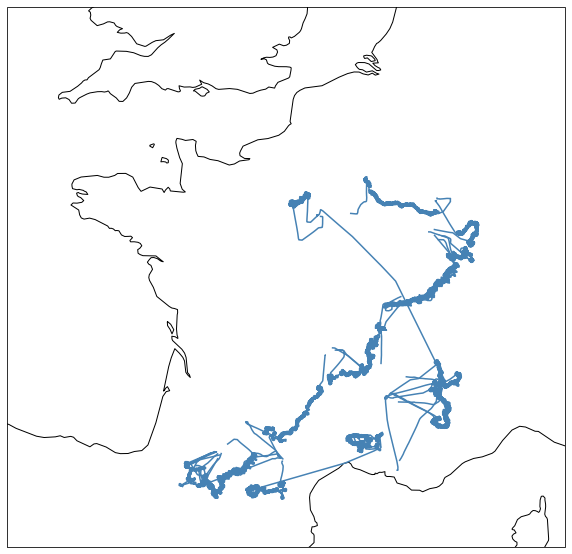

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
from cartopy.crs import EuroPP, PlateCarree

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=EuroPP()))
ax.coastlines("50m")

for flight in collection:
    flight.data.plot(
        ax=ax,
        x="longitude",
        y="latitude",
        legend=False,
        transform=PlateCarree(),
        color="steelblue",
    )

ax.set_extent((-5, 10, 42, 52))
ax.set_yticks([])

<div class='alert alert-warning'>
    <b>Exercice:</b> Implement a plot method to make the job even more simple.
</div>

In [90]:
from cartopy.crs import PlateCarree

class Flight:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return (
            f"Flight {self.callsign} with aircraft {self.icao24} "
            f"on {self.min('timestamp'):%Y-%m-%d}"
        )

    def __lt__(self, other):
        return self.min("timestamp") <= other.min("timestamp")

    def max(self, feature):
        return self.data[feature].max()

    def min(self, feature):
        return self.data[feature].min()

    def plot(self, ax, color="steelblue"):
        self.data.plot(
            ax=ax,
            x="longitude",
            y="latitude",
            legend=False,
            transform=PlateCarree(),
            color=color,
        )

    @property
    def callsign(self):
        return self.min("callsign")

    @property
    def icao24(self):
        return self.min("icao24")

In [92]:
# %load solutions/flight_plot.py
class Flight:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return (
            f"Flight {self.callsign} with aircraft {self.icao24} "
            f"on {self.min('timestamp'):%Y-%m-%d} "
        )

    def __lt__(self, other):
        return self.min("timestamp") <= other.min("timestamp")

    def max(self, feature):
        return self.data[feature].max()

    def min(self, feature):
        return self.data[feature].min()

    @property
    def callsign(self):
        return self.min("callsign")

    @property
    def icao24(self):
        return self.min("icao24")

    def plot(self, ax, **kwargs):
        self.data.plot(
            ax=ax,
            x="longitude",
            y="latitude",
            legend=False,
            transform=PlateCarree(),
            **kwargs,
        )


[]

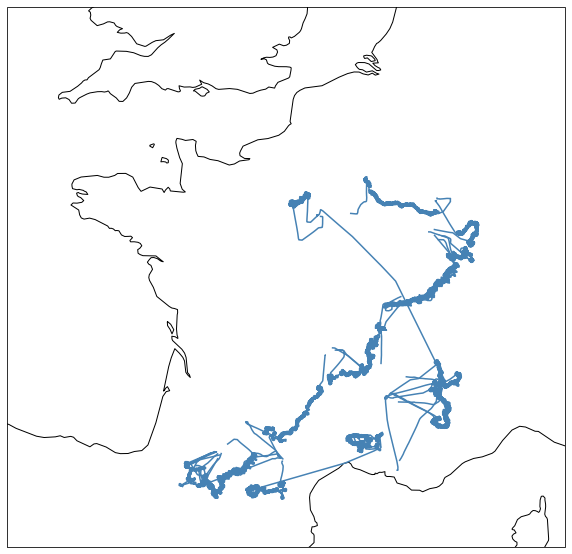

In [96]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=EuroPP()))
ax.coastlines("50m")

for flight in collection:
    flight.plot(ax, color="steelblue")

ax.set_extent((-5, 10, 42, 52))
ax.set_yticks([])

## Indexation

Until now, we implemented all what is necessary to iterate on structures.  
This means we have all we need to yield elements one after the other.

Note that:
- Python does not assume your structure has a length.  
  (There are some infinite iterators, like the one yielding natural integers one after the other.)
- Python cannot guess for you how you want to index your flights.


In [97]:
len(collection)

TypeError: object of type 'FlightCollection' has no len()

In [98]:
collection['ASR172B']

TypeError: 'FlightCollection' object is not subscriptable

There are many ways to proceed with indexing. We may want to select flights with a specific callsign, or a specific icao24 code. Also, if only one Flight is returned, we want a Flight object. If two or more segments are contained in the underlying dataframe, we want to stick to a FlightCollection.

<div class="alert alert-warning">
    <b>Exercice:</b> Implement a <code>__len__</code> special method, then a <code>__getitem__</code> special method that will return a Flight or a FlightCollection (depending on the selection) wrapping data corresponding to the given callsign or icao24 code.
</div>

In [237]:
class FlightCollection:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"FlightCollection with {len(self)} flights"

    @classmethod
    def read_json(cls, filename):
        return cls(pd.read_json(filename))

    def __iter__(self):
        for group in iterate_icao24_callsign(self.data):
            for elt in iterate_time(group, 20000):
                yield Flight(elt)

    def __len__(self):
        return sum(1 for _ in self)
    
    def __getitem__(self, key):
        item = FlightCollection(self.data.query(f"icao24 == '{key}' or callsign == '{key}'")) 
        return (Flight(item.data) if len(item) == 1 else item)


In [221]:
# %load solutions/flight_index.py
class FlightCollection:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"FlightCollection with {len(self)} flights"

    @classmethod
    def read_json(cls, filename):
        return cls(pd.read_json(filename))

    def __iter__(self):
        for group in iterate_icao24_callsign(self.data):
            for elt in iterate_time(group, 20000):
                yield Flight(elt)

    def __len__(self):
        return sum(1 for _ in self)

    def __getitem__(self, key):
        result = FlightCollection(
            self.data.query(f"callsign == '{key}' or icao24 == '{key}'")
        )

        if len(result) == 1:
            return Flight(result.data)
        else:
            return result


In [238]:
collection = FlightCollection.read_json("data/tour_de_france.json.gz")
collection

FlightCollection with 26 flights

In [239]:
collection["3924a0"]

Flight ASR172B with aircraft 3924a0 on 2019-07-25 

In [240]:
collection["ASR172B"]

FlightCollection with 19 flights

In [241]:
from collections import defaultdict

count = defaultdict(int)
for flight in collection["ASR172B"]:
    count[flight.icao24] += 1

count

defaultdict(int, {'3924a0': 1, '3924a4': 18})

As we can see here, this method for indexing is not convenient enough. We could select the only flight `collection["ASR172B"]["3924a0"]` but with current implementation, there is no way to separate the 18 other flights.

<div class='alert alert-warning'>
    <b>Exercice:</b> Implement a different <code>__getitem__</code> method that checks the type of the index: filter on callsign/icao24 if the key is a <code>str</code>, filter on the day of the flight if the key is a <code>pd.Timestamp</code>.
</div>

In [322]:
class FlightCollection:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"FlightCollection with {len(self)} flights"

    @classmethod
    def read_json(cls, filename):
        return cls(pd.read_json(filename))

    def __iter__(self):
        for group in iterate_icao24_callsign(self.data):
            for elt in iterate_time(group, 20000):
                yield Flight(elt)

    def __len__(self):
        return sum(1 for _ in self)

    def __getitem__(self, key):
        if type(key) is str:
            item = FlightCollection(self.data.query(f"icao24 == '{key}' or callsign == '{key}'")) 
        if type(key) is pd.Timestamp:
            item = FlightCollection(self.data.query(f"'{key}' < timestamp < '{key+timedelta(days=1)}'"))
        return (Flight(item.data) if len(item) == 1 else item)



In [312]:
a = "test"
type(a) is str
date = pd.Timestamp("2019-07-18")
collection.data.query(f"'{date}' < timestamp < '{date+timedelta(days=1)}'")

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
19873,2019-07-18 09:02:40,3924a4,43.566424,1.453073,150.920378,335.462272,0.0,ASR172B,24900.0
19874,2019-07-18 09:02:50,3924a4,43.567820,1.453073,150.096506,335.462272,0.0,ASR172B,24900.0
19875,2019-07-18 09:03:00,3924a4,43.574524,1.453073,150.096506,335.462272,0.0,ASR172B,24900.0
19876,2019-07-18 09:03:10,3924a4,43.580658,1.453073,150.096506,327.792302,0.0,ASR172B,24900.0
19877,2019-07-18 09:03:20,3924a4,43.586395,1.453073,149.000000,325.885527,0.0,ASR172B,24900.0
...,...,...,...,...,...,...,...,...,...
53393,2019-07-18 13:52:10,39bd17,43.273853,-0.119065,134.000000,256.000000,-704.0,PXR26M,3700.0
53394,2019-07-18 13:52:20,39bd17,43.271599,-0.119065,131.000000,256.000000,-704.0,PXR26M,3500.0
53395,2019-07-18 13:52:30,39bd17,43.269978,-0.119065,130.000000,256.000000,-704.0,PXR26M,3442.0
53396,2019-07-18 13:52:40,39bd17,43.269728,-0.119065,130.000000,256.000000,-704.0,PXR26M,3371.0


In [318]:
# %load solutions/flight_index_time.py
from datetime import timedelta


class FlightCollection:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"FlightCollection with {len(self)} flights"

    @classmethod
    def read_json(cls, filename):
        return cls(pd.read_json(filename))

    def __iter__(self):
        for group in iterate_icao24_callsign(self.data):
            for elt in iterate_time(group, 20000):
                yield Flight(elt)

    def __len__(self):
        return sum(1 for _ in self)

    def __getitem__(self, key):
        if isinstance(key, str):
            result = FlightCollection(
                self.data.query("callsign == @key or icao24 == @key")
            )
        if isinstance(key, pd.Timestamp):
            before = key
            after = key + timedelta(days=1)
            result = FlightCollection(self.data.query("@before < timestamp < @after"))

        if len(result) == 1:
            return Flight(result.data)
        else:
            return result


In [320]:
collection = FlightCollection.read_json("data/tour_de_france.json.gz")

In [323]:
collection["ASR172B"][pd.Timestamp("2019-07-18")]

Flight ASR172B with aircraft 3924a4 on 2019-07-18 

<div class='alert alert-warning'>
    <b>Exercice:</b> Plot all trajectories flying on July 18th. How can they be sure to not collide with each other?
</div>

{'ASR172B': 24925.0, 'ASR171A': 23000.0, 'PXR31M': 11100.0, 'PXR26M': 10000.0}

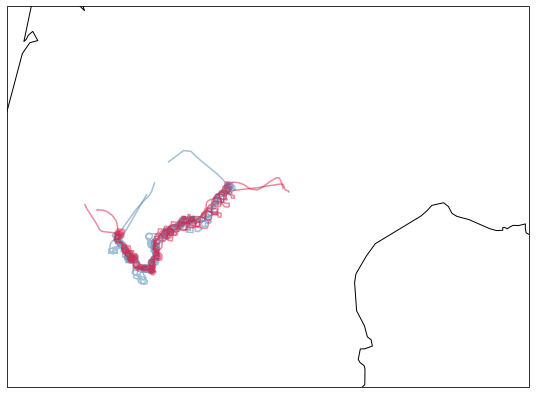

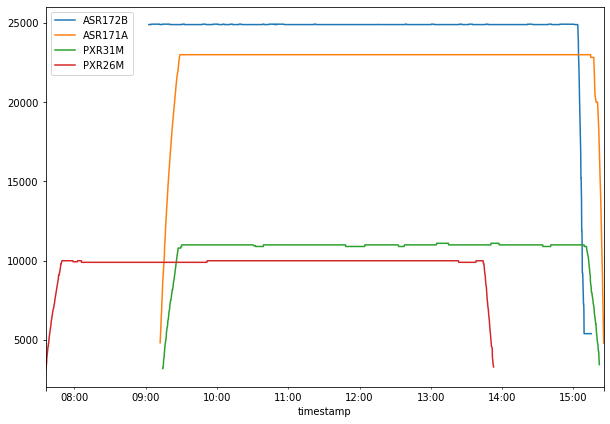

In [326]:
# %load solutions/flight_plot_july18.py
from cartopy.crs import EuroPP, PlateCarree

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(projection=EuroPP()))
ax.coastlines("50m")

for flight in collection[pd.Timestamp("2019-07-18")]:
    flight.plot(
        ax,
        color="crimson" if flight.callsign.startswith("PXR") else "steelblue",
        alpha=0.5,
    )

ax.set_extent((-1, 5, 42, 45))
ax.set_yticks([])

fig, ax = plt.subplots(figsize=(10, 7))
for flight in collection[pd.Timestamp("2019-07-18")]:
    flight.data.plot(ax=ax, x="timestamp", y="altitude", label=flight.callsign)

# All flights fly at a different altitude, ensuring that they don't collide.
# Note that the PXR missions are aircraft taking pictures of the Tour while the
# ASR missions fly at a higher altitude to catch their signals and broadcast it
# to static ground stations for live TV programs.

dict(
    (f.callsign, f.max("altitude"))
    for f in collection[pd.Timestamp("2019-07-18")]
)


In [324]:
collection[pd.Timestamp("2019-07-18")]

FlightCollection with 4 flights

[]

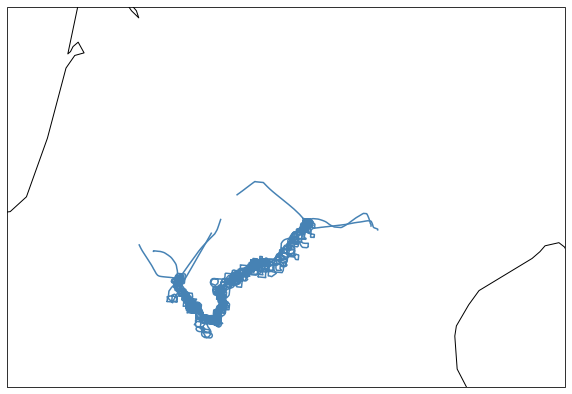

In [338]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=EuroPP()))
ax.coastlines("50m")

for flight in collection[pd.Timestamp("2019-07-18")]:
    flight.plot(ax, color="steelblue")

ax.set_extent((-1.5, 4, 42.5, 45))
ax.set_yticks([])